In [1]:
#this kmeans implementation is inspired by this code: https://stackoverflow.com/questions/40752088/extract-images-from-clusters-separately-in-kmeans-python
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2 
import sys
import pickle
import sklearn
from sklearn.externals import joblib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os 
from skimage.feature import local_binary_pattern 
# To calculate a normalized histogram
from scipy.stats import itemfreq 
from sklearn.preprocessing import normalize 
import cvutils 
import csv 
import numpy 
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.cluster import KMeans

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
train_path = 'stage1_train/'
train_ids = os.listdir(train_path)

In [3]:
X_paths = []
X_test = []

for id_ in train_ids:
    train_paths = train_path + id_ + '/images/' + id_ + '.png'
    # Read the image using cv2 package
    im = cv2.imread(train_paths)
    # Convert to grayscale as Local Binary Pattern (LBP) works on grayscale image
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    radius = 3
    # Number of points to be considered as neighbors 
    neighbor_points = 10 * radius

    # Uniform LBP is used
    lbp = local_binary_pattern(im_gray, neighbor_points, radius, method='uniform')

    # Calculate the histogram
    x = itemfreq(lbp.ravel())


    # Normalize the histogram
    hist = x[:, 1]/sum(x[:, 1])


    # Append image path in X_paths
    X_paths.append(train_paths)

    # Append histogram to X_test
    X_test.append(hist)


In [4]:
joblib.dump((X_paths, X_test), 'lbp.pkl', compress=3)

['lbp.pkl']

In [5]:
X_test = np.array(X_test)

In [6]:
pca = PCA(n_components = 15)

In [7]:
pca.fit(X_test)
pca_activations = pca.transform(X_test)

In [8]:
print(X_test.shape)

(664, 32)


In [20]:
X = np.array(pca_activations)
tsne = TSNE(n_components=2, learning_rate=500, perplexity=50, verbose=2, angle=0.2, early_exaggeration=7.0).fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 664 samples in 0.000s...
[t-SNE] Computed neighbors for 664 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 664 / 664
[t-SNE] Mean sigma: 0.027553
[t-SNE] Computed conditional probabilities in 0.070s
[t-SNE] Iteration 50: error = 26.2782593, gradient norm = 0.2266652 (50 iterations in 1.020s)
[t-SNE] Iteration 100: error = 26.0171642, gradient norm = 0.2336720 (50 iterations in 0.953s)
[t-SNE] Iteration 150: error = 25.7497005, gradient norm = 0.2342715 (50 iterations in 0.977s)
[t-SNE] Iteration 200: error = 25.6402092, gradient norm = 0.2338035 (50 iterations in 0.955s)
[t-SNE] Iteration 250: error = 26.0093365, gradient norm = 0.2347455 (50 iterations in 0.955s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 26.009336
[t-SNE] Iteration 300: error = 0.2915880, gradient norm = 0.0008310 (50 iterations in 0.887s)
[t-SNE] Iteration 350: error = 0.2570660, gradient norm = 0.0015697 

In [21]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
print(tsne.shape)

(664, 2)


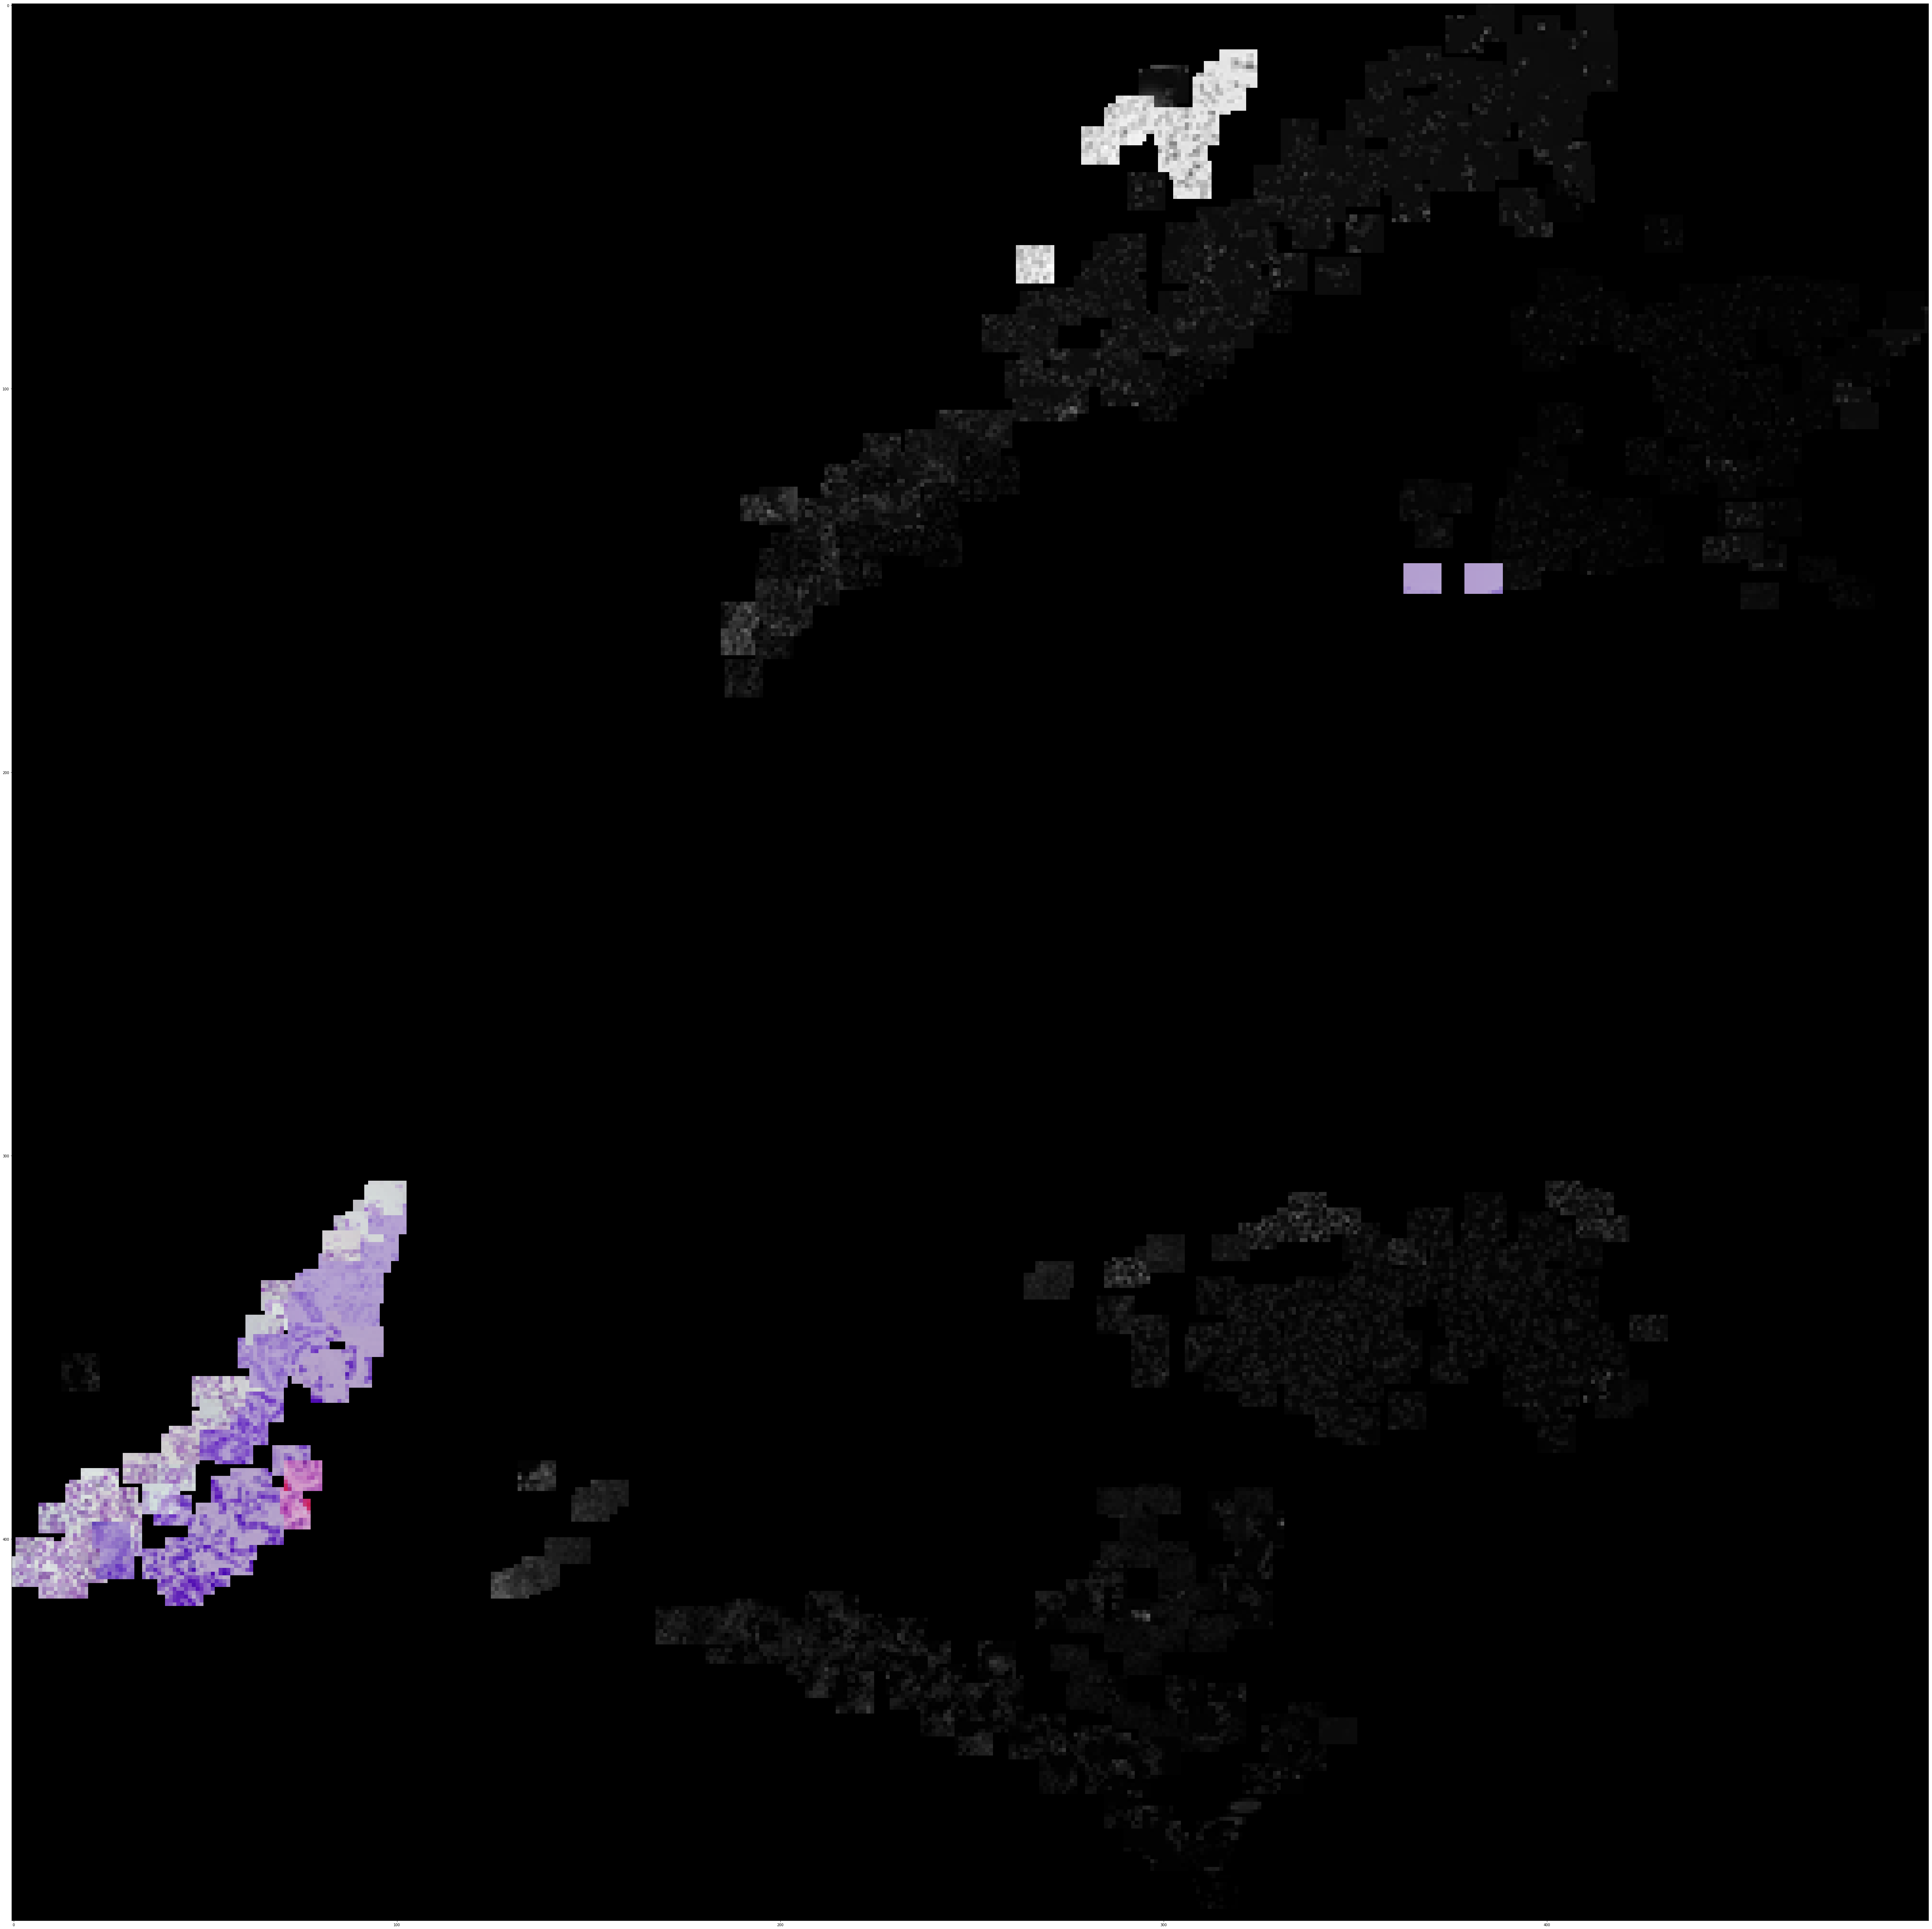

In [22]:
width = 500
height = 500
max_dim = 10

full_image = Image.new('RGB', (width, height))
for img, x, y in zip(X_paths, tx, ty):
    #print "for loop"
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)))
full_image.save("myTSNE.png")

matplotlib.pyplot.figure(figsize = (100,100))
plt.imshow(full_image)

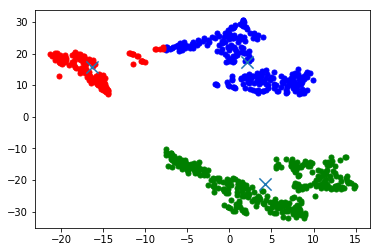

In [23]:
#Convert Images to Float32 
images = np.asarray(tsne, np.float32)
N = len(images)
images = images.reshape(N,-1)

#using kmeans clustring having 5 clusters
kmeans = KMeans(n_clusters=3)

#passing images to kmeans 
kmeans.fit(images)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

colors = 10*['r.','g.','b.','c.','k.','y.','m.']

for i in range(len(images)):
    #print("coordinate:",images[i], "label:", labels[i])
    plt.plot(images[i][0], images[i][1], colors[labels[i]], markersize = 10)

    img = cv2.convertScaleAbs(images[i])
    #print("Images Type", img.dtype)

    #pin=sorted([int(n[:n.find('.')]) for n in os.listdir(train_path)
                #if n[0]!='.' ]+[0])[-1] + 1
    #cv2.imwrite('%s/%s.png' % (path, pin), img)




plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 20)

plt.show()